# Preparation

사전학습된 모델들을 pytorch에서 사용하기 위해 timm 모듈을 이용해보자

(torchvision보다 더 많은 pretrained 모델을 지원함)

optimizers, schedulers, data-loaders, augmentations 등 다양한 기능들을 제공


In [ ]:
%%capture
!pip install timm
# %%capture를 하면 코드의 아웃풋이 안 보인다 (깔끔)

In [ ]:
import os
import matplotlib.pyplot as plt
import numpy as np
import PIL

import torch
import torch.nn.functional as F
import torchvision
import torchvision.transforms as T

from timm import create_model

10 represents the maximum length of the source sequences within the batch. It indicates that the longest source sequence in the batch has 10 tokens or elements.


"32" refers to the batch size. It means there are 32 parallel source sequences processed simultaneously.

"512" refers to the embedding dimension. It means each token or element in the sequence is represented by a vector of length 512.

In [ ]:
src = torch.rand(10, 32, 512)
tgt = torch.rand(20, 32, 512)  

transformer_model = torch.nn.Transformer(nhead=16, num_encoder_layers=12)

out = transformer_model(src, tgt)

torch.nn.modules.transformer.Transformer

In [ ]:
src = torch.rand(10, 512)
tgt = torch.rand(20, 512)  

transformer_model = torch.nn.Transformer(nhead=16, num_encoder_layers=12)

out = transformer_model(src, tgt)

out.shape

torch.Size([20, 512])

# Prepare Model and Data

In [ ]:
model_name = "vit_base_patch16_224"
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("device = ", device)
# create a ViT model : https://github.com/rwightman/pytorch-image-models/blob/master/timm/models/vision_transformer.py
model = create_model(model_name, pretrained=True).to(device)

device =  cuda


In [ ]:
print(model)

VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
    (norm): Identity()
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (patch_drop): Identity()
  (norm_pre): Identity()
  (blocks): Sequential(
    (0): Block(
      (norm1): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=768, out_features=2304, bias=True)
        (q_norm): Identity()
        (k_norm): Identity()
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=768, out_features=768, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (ls1): Identity()
      (drop_path1): Identity()
      (norm2): LayerNorm((768,), eps=1e-06, elementwise_affine=True)
      (mlp): Mlp(
        (fc1): Linear(in_features=768, out_features=3072, bias=True)
        (act): GELU(approximate='none')
        (drop1): Dropout(p=0.0, inplace=False)
        (norm): Identity(

In [ ]:
%%capture
!pip3 install pytorch-model-summary

In [ ]:
import pytorch_model_summary

In [ ]:
print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 224, 224).to('cuda'), show_input=True))   # 다른 크기 인풋은?

------------------------------------------------------------------------
      Layer (type)          Input Shape         Param #     Tr. Param #
      PatchEmbed-1     [1, 3, 224, 224]         590,592         590,592
         Dropout-2        [1, 197, 768]               0               0
        Identity-3        [1, 197, 768]               0               0
        Identity-4        [1, 197, 768]               0               0
           Block-5        [1, 197, 768]       7,087,872       7,087,872
           Block-6        [1, 197, 768]       7,087,872       7,087,872
           Block-7        [1, 197, 768]       7,087,872       7,087,872
           Block-8        [1, 197, 768]       7,087,872       7,087,872
           Block-9        [1, 197, 768]       7,087,872       7,087,872
          Block-10        [1, 197, 768]       7,087,872       7,087,872
          Block-11        [1, 197, 768]       7,087,872       7,087,872
          Block-12        [1, 197, 768]       7,087,872       7

In [ ]:
print(pytorch_model_summary.summary(model, torch.zeros(1, 3, 224, 224).to('cuda'), show_input=False))

-----------------------------------------------------------------------
      Layer (type)        Output Shape         Param #     Tr. Param #
      PatchEmbed-1       [1, 196, 768]         590,592         590,592
         Dropout-2       [1, 197, 768]               0               0
        Identity-3       [1, 197, 768]               0               0
        Identity-4       [1, 197, 768]               0               0
           Block-5       [1, 197, 768]       7,087,872       7,087,872
           Block-6       [1, 197, 768]       7,087,872       7,087,872
           Block-7       [1, 197, 768]       7,087,872       7,087,872
           Block-8       [1, 197, 768]       7,087,872       7,087,872
           Block-9       [1, 197, 768]       7,087,872       7,087,872
          Block-10       [1, 197, 768]       7,087,872       7,087,872
          Block-11       [1, 197, 768]       7,087,872       7,087,872
          Block-12       [1, 197, 768]       7,087,872       7,087,872
     

In [ ]:
# Define transforms for test
IMG_SIZE = (224, 224)
NORMALIZE_MEAN = (0.5, 0.5, 0.5)
NORMALIZE_STD = (0.5, 0.5, 0.5)
transforms = [
              T.Resize(IMG_SIZE),
              T.ToTensor(),
              T.Normalize(NORMALIZE_MEAN, NORMALIZE_STD),
              ]

transforms = T.Compose(transforms)

In [ ]:
%%capture
# ImageNet Labels
!wget https://storage.googleapis.com/bit_models/ilsvrc2012_wordnet_lemmas.txt
imagenet_labels = dict(enumerate(open('ilsvrc2012_wordnet_lemmas.txt')))

# Demo Image
!wget https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/santorini.png?raw=true -O santorini.png
img = PIL.Image.open('santorini.png')
img_tensor = transforms(img).unsqueeze(0).to(device)

# Simple Inference

In [ ]:
# end-to-end inference
output = model(img_tensor)

In [ ]:
output.shape

torch.Size([1, 1000])

Inference Result:
church, church_building



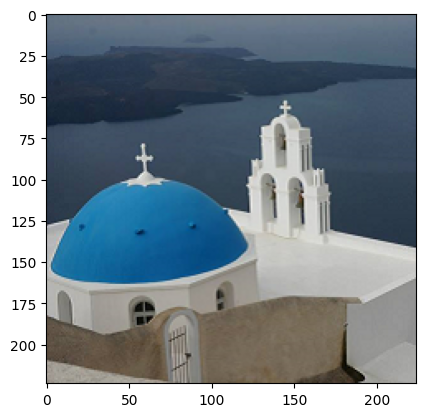

In [ ]:
print("Inference Result:")
print(imagenet_labels[int(torch.argmax(output))])
plt.imshow(img)

# Dig into Vision Transformer

Let's look at the details of the Vision Transformer!


<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/vit_input.png?raw=true'>

Vision Transformer inference pipeline.  

1. 이미지를 패치단위로 나눈다  
input 이미지 사이즈 = 224 x 224  
patch 사이즈 = 16 x 16  
224 / 16 = 14이므로 총 14 x 14개의 patch들이 생성됨  
convolution layer를 통해 각각의 patch들을 768차원 벡터로 만들어줌  
여기서 Conv2d ---> (k=16x16) with stride=(16, 16). 
2. Position Embeddings  
위에서 만든 patch embedding 벡터들에 position embedding을 더해줘서 인코더에 넣는다  
3. Transformer Encoder  
인코더를 이용해 embedding vector들을 인코딩한다.  
input과 output 벡터의 차원은 동일하다  
4. MLP (Classification) Head  
인코더 output의 0th는 class token이므로 이를 MLP head에 넣어서 classification을 수행한다

# 1. Split Image into Patches

input 이미지는 N개의 patch들로 나눠진다 (N = 14 x 14 for ViT-Base)

그리고 D=768차원의 embedding vector들로 변환된다. (by learnable 2D convolution)
```
Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
```

In [ ]:
patches = model.patch_embed(img_tensor)  # patch embedding convolution
print("Image tensor: ", img_tensor.shape)
print("Patch embeddings: ", patches.shape)

Image tensor:  torch.Size([1, 3, 224, 224])
Patch embeddings:  torch.Size([1, 196, 768])


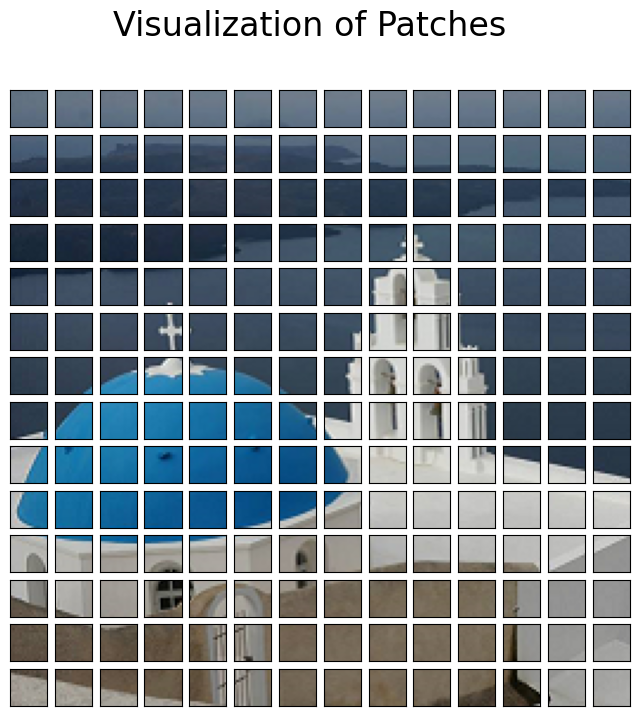

In [ ]:
# This is NOT a part of the pipeline.
# Actually the image is divided into patch embeddings by Conv2d 
# with stride=(16, 16) shown above.
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of Patches", fontsize=24)
img = np.asarray(img)
for i in range(0, 196):
    x = i % 14
    y = i // 14
    patch = img[y*16:(y+1)*16, x*16:(x+1)*16]
    ax = fig.add_subplot(14, 14, i+1)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(patch)

# 2. Add Position Embeddings
patch들에 위치정보를 주기 위해 학습가능한 'position embedding' 벡터들을 patch embedding 벡터들에 더해준다.

position embedding 벡터들은 image 내에서의 거리

(가까우면 높은 유사도)

### Visualization of position embeddings

In [ ]:
pos_embed = model.pos_embed
print(pos_embed.shape)

torch.Size([1, 197, 768])


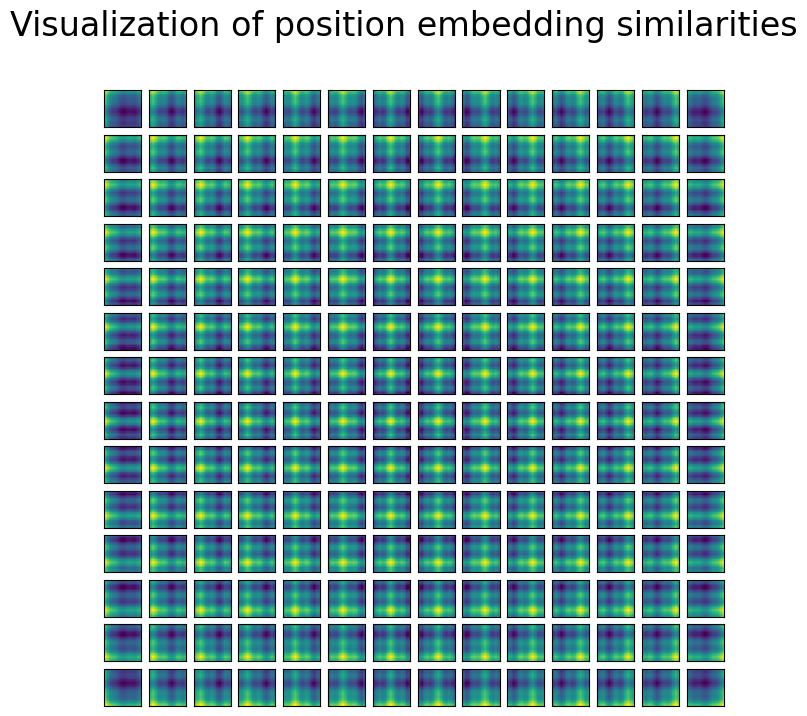

In [ ]:
# Visualize position embedding similarities.
# One cell shows cos similarity between an embedding and all the other embeddings.
cos = torch.nn.CosineSimilarity(dim=1, eps=1e-6)
fig = plt.figure(figsize=(8, 8))
fig.suptitle("Visualization of position embedding similarities", fontsize=24)
for i in range(1, pos_embed.shape[1]):
    sim = F.cosine_similarity(pos_embed[0, i:i+1], pos_embed[0, 1:], dim=1)
    sim = sim.reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(14, 14, i)
    ax.axes.get_xaxis().set_visible(False)
    ax.axes.get_yaxis().set_visible(False)
    ax.imshow(sim)

### Make Transformer Input
학습가능한 class token을 patch embedding 앞에 붙여준다

즉, 197 (1 + 14 x 14) learnable position embedding 벡터가 patch embedding 벡터에 더해진다

In [ ]:
transformer_input = torch.cat((model.cls_token, patches), dim=1) + pos_embed
print("Transformer input: ", transformer_input.shape)

Transformer input:  torch.Size([1, 197, 768])


# 3. Transformer Encoder
<img src='https://github.com/hirotomusiker/schwert_colab_data_storage/blob/master/images/vit_demo/transformer_encoder.png?raw=true'>

Transformer Encoder  
- N (=197) embedded vectors are fed to the L (=12) series encoders. 
- The vectors are divided into query, key and value after expanded by an fc layer. 
- q, k and v are further divided into H (=12) and fed to the parallel attention heads. 
- Outputs from attention heads are concatenated to form the vectors whose shape is the same as the encoder input.
- The vectors go through an fc, a layer norm and an MLP block that has two fc layers.

The Vision Transformer employs the Transformer Encoder that was proposed in the [attention is all you need paper](https://papers.nips.cc/paper/2017/file/3f5ee243547dee91fbd053c1c4a845aa-Paper.pdf). 


### Series Transformer Encoders

In [ ]:
print("Input tensor to Transformer (z0): ", transformer_input.shape)
x = transformer_input.clone()
for i, blk in enumerate(model.blocks):
    print("Entering the Transformer Encoder {}".format(i))
    x = blk(x)
x = model.norm(x)
transformer_output = x[:, 0]
print("Output vector from Transformer (z12-0):", transformer_output.shape)

Input tensor to Transformer (z0):  torch.Size([1, 197, 768])
Entering the Transformer Encoder 0
Entering the Transformer Encoder 1
Entering the Transformer Encoder 2
Entering the Transformer Encoder 3
Entering the Transformer Encoder 4
Entering the Transformer Encoder 5
Entering the Transformer Encoder 6
Entering the Transformer Encoder 7
Entering the Transformer Encoder 8
Entering the Transformer Encoder 9
Entering the Transformer Encoder 10
Entering the Transformer Encoder 11
Output vector from Transformer (z12-0): torch.Size([1, 768])


## How Attention Works

In this part, we are going to see what the actual attention looks like.

In [ ]:
print("Transformer Multi-head Attention block:")
attention = model.blocks[0].attn
print(attention)
print("input of the transformer encoder:", transformer_input.shape)

Transformer Multi-head Attention block:
Attention(
  (qkv): Linear(in_features=768, out_features=2304, bias=True)
  (q_norm): Identity()
  (k_norm): Identity()
  (attn_drop): Dropout(p=0.0, inplace=False)
  (proj): Linear(in_features=768, out_features=768, bias=True)
  (proj_drop): Dropout(p=0.0, inplace=False)
)
input of the transformer encoder: torch.Size([1, 197, 768])


In [ ]:
# fc layer to expand the dimension
transformer_input_expanded = attention.qkv(transformer_input)[0]
print("expanded to: ", transformer_input_expanded.shape)

expanded to:  torch.Size([197, 2304])


In [ ]:
# Split qkv into mulitple q, k, and v vectors for multi-head attantion
qkv = transformer_input_expanded.reshape(197, 3, 12, 64)  # (N=197, (qkv), H=12, D/H=64)
print("split qkv : ", qkv.shape)
q = qkv[:, 0].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
k = qkv[:, 1].permute(1, 0, 2)  # (H=12, N=197, D/H=64)
kT = k.permute(0, 2, 1)  # (H=12, D/H=64, N=197)
print("transposed ks: ", kT.shape)

split qkv :  torch.Size([197, 3, 12, 64])
transposed ks:  torch.Size([12, 64, 197])


attention matrix:  torch.Size([12, 197, 197])


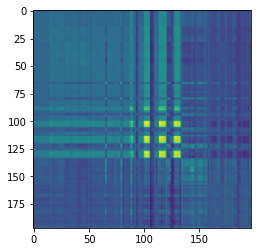

In [ ]:
# Attention Matrix
attention_matrix = q @ kT
print("attention matrix: ", attention_matrix.shape)
plt.imshow(attention_matrix[3].detach().cpu().numpy())

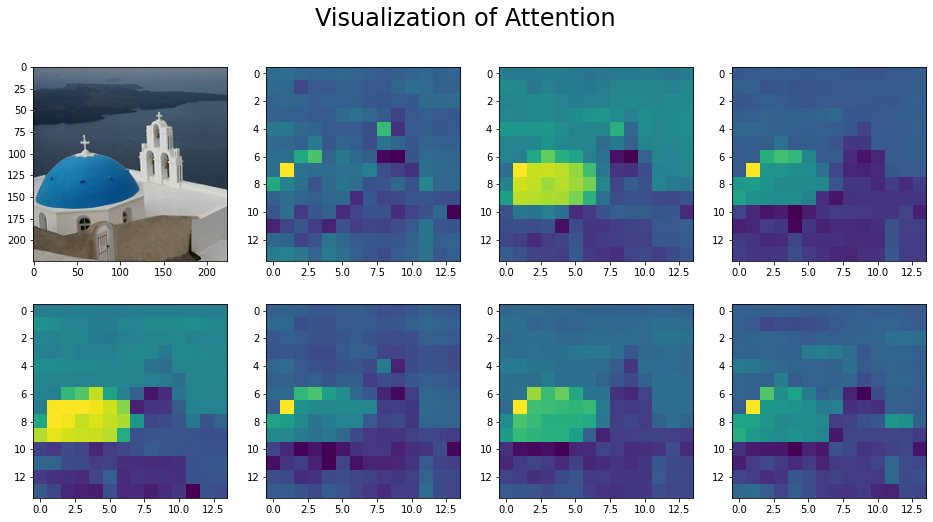

In [ ]:
# Visualize attention matrix
fig = plt.figure(figsize=(16, 8))
fig.suptitle("Visualization of Attention", fontsize=24)
fig.add_axes()
img = np.asarray(img)
ax = fig.add_subplot(2, 4, 1)
ax.imshow(img)
for i in range(7):  # visualize the 100th rows of attention matrices in the 0-7th heads
    attn_heatmap = attention_matrix[i, 100, 1:].reshape((14, 14)).detach().cpu().numpy()
    ax = fig.add_subplot(2, 4, i+2)
    ax.imshow(attn_heatmap)

# 4. MLP (Classification) Head
The 0-th output vector from the transformer output vectors (corresponding to the class token input) is fed to the MLP head.  
The 1000-dimension classification result is the output of the whole pipeline.

Classification head:  Linear(in_features=768, out_features=1000, bias=True)
Inference result : id = 538, label name = dome



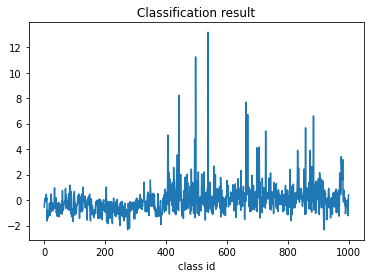

In [ ]:
print("Classification head: ", model.head)
result = model.head(transformer_output)
result_label_id = int(torch.argmax(result))
plt.plot(result.detach().cpu().numpy()[0])
plt.title("Classification result")
plt.xlabel("class id")
print("Inference result : id = {}, label name = {}".format(
    result_label_id, imagenet_labels[result_label_id]))

#Training!

https://velog.io/@gtpgg1013/pytorch-Image-Classification-Using-ViT  
https://csm-kr.tistory.com/80  
https://deep-learning-study.tistory.com/807  